In [1]:
embedding = "sceptr-tiny-autoencoder"
# embedding = "aaprop-autoencoder"
# embedding = "atchley-no-reduction"

In [2]:
from pathlib import Path

dir = Path.cwd() / f"results/{embedding}/"

if not dir.exists():
    raise FileNotFoundError

folders = list(dir.glob("kfold-*"))

data = {}

for folder in folders:
    data[str(folder.relative_to(dir))] = {
        "train": [i.relative_to(dir / folder) for i in folder.glob("Epoch */train-records.csv")],
        "test": [i.relative_to(dir / folder) for i in folder.glob("Epoch */test-records.csv")],
        # "eval": [i.relative_to(dir / folder) for i in folder.glob("Epoch */eval-records.csv")],
    }


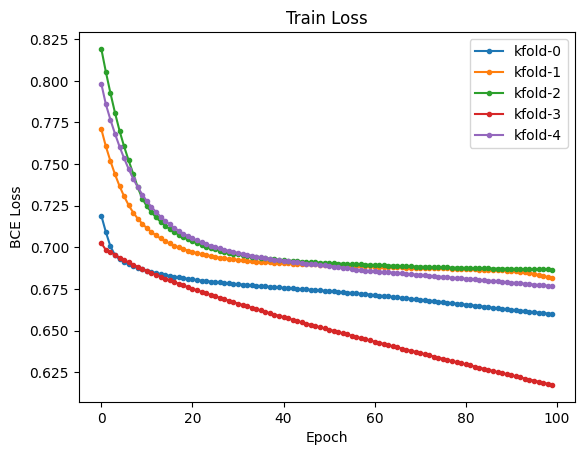

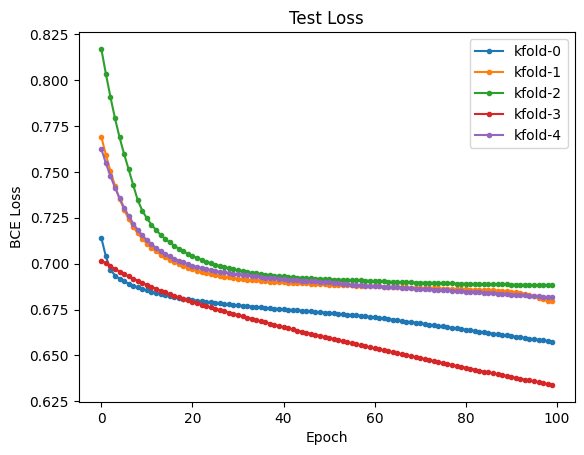

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_loss_result(category):
    for kfold, results in data.items():
        plotting = []
        for train_record in results[category]:
            df = pd.read_csv(Path.cwd() / dir / kfold / train_record)
            plotting.append((int(str(train_record.parent).replace("Epoch ", "")), df["loss"].mean()))
        plt.plot(*zip(*sorted(plotting)), marker = ".", label = kfold)

    plt.title(f"{category.title()} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("BCE Loss")
    plt.legend()
    plt.show()

plot_loss_result("train")
plot_loss_result("test")
# plot_loss_result("eval")

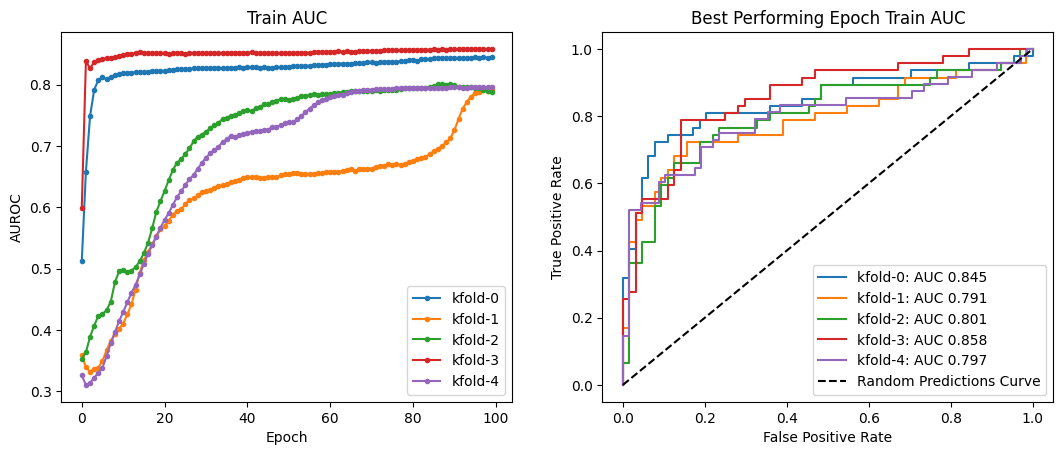

K-Fold CV Train AUC: 0.8182897893199834


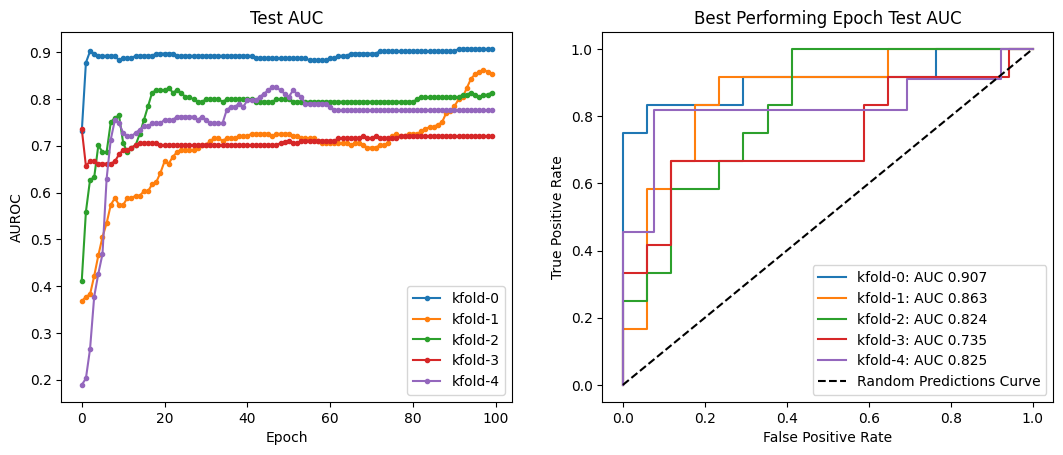

K-Fold CV Test AUC: 0.8307212395447688


In [4]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

def plot_auc_result(category):
    best_aucs = []
    fig, axs = plt.subplots(ncols = 2, figsize = [plt.rcParams["figure.figsize"][0] * 2, plt.rcParams["figure.figsize"][1]])

    for kfold, results in data.items():
        plotting = []
        for train_record in results[category]:
            df = pd.read_csv(Path.cwd() / dir / kfold / train_record)
            plotting.append((
                int(str(train_record.parent).replace("Epoch ", "")), 
                roc_auc_score(df["actual"], df["pred"])
            ))
        axs[0].plot(*zip(*sorted(plotting)), marker = ".", label = kfold)
        
        plotting.sort(key = lambda x: -x[1])
        best_epoch = plotting[0][0]
        best_aucs.append(plotting[0][1])
        df = pd.read_csv(Path.cwd() / dir / kfold / f"Epoch {best_epoch}/{category}-records.csv")
        fpr, tpr, thresholds = roc_curve(df["actual"], df["pred"])
        axs[1].plot(fpr, tpr, label = f"{kfold}: AUC {round(best_aucs[-1], 3)}")

    axs[0].set_title(f"{category.title()} AUC")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("AUROC")
    axs[0].legend()
    
    axs[1].plot([0, 1], [0, 1], "k--", label = "Random Predictions Curve")
    axs[1].set_title(f"Best Performing Epoch {category.title()} AUC")
    axs[1].set_xlabel("False Positive Rate")
    axs[1].set_ylabel("True Positive Rate")
    axs[1].legend()
    plt.show()
    print (f"K-Fold CV {category.title()} AUC: {np.mean(best_aucs)}")

plot_auc_result("train")
# plot_auc_result("eval")
plot_auc_result("test")

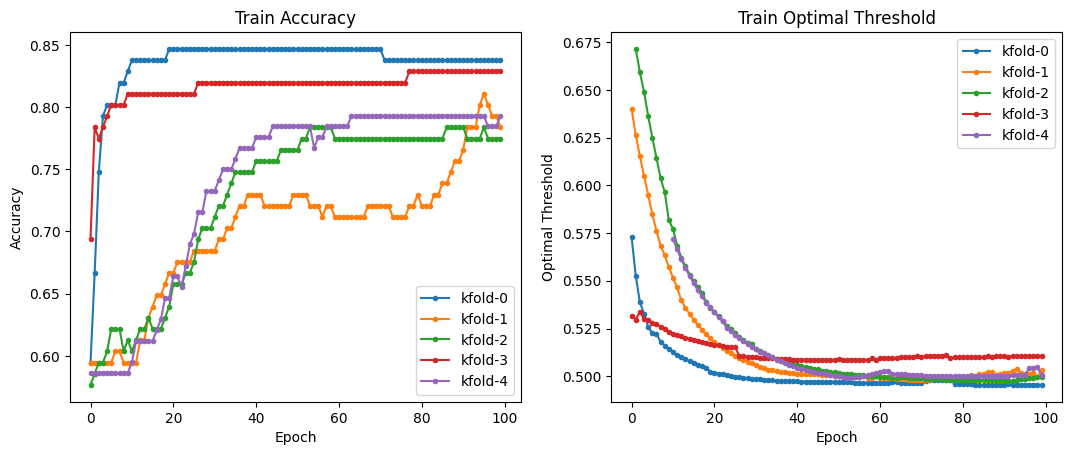

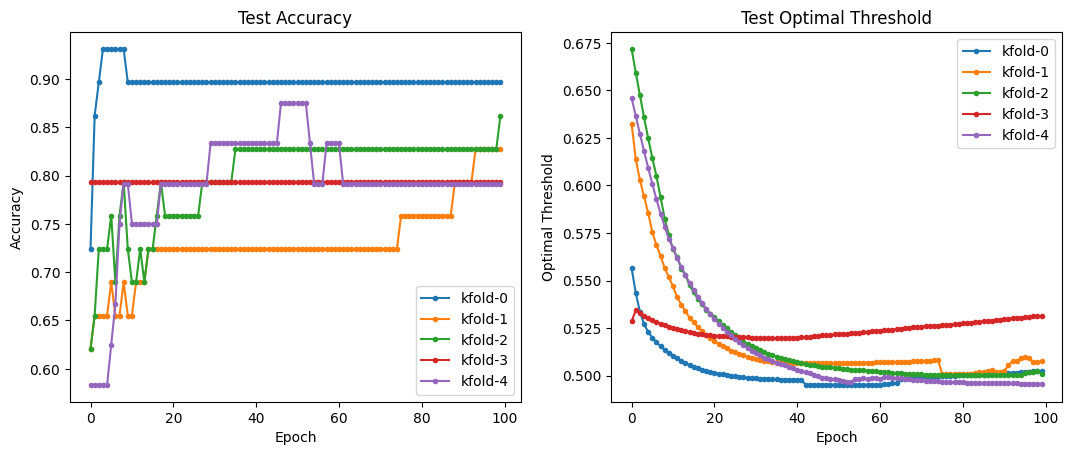

In [5]:
import numpy as np

def plot_acc_result(category):
    fig, axs = plt.subplots(ncols = 2, figsize = [plt.rcParams["figure.figsize"][0] * 2, plt.rcParams["figure.figsize"][1]])
    for kfold, results in data.items():
        optim_threshold = []
        optim_accuracy = []
        for train_record in results[category]:
            df = pd.read_csv(Path.cwd() / dir / kfold / train_record)
            fpr, tpr, thresholds = roc_curve(df["actual"], df["pred"])
            P = np.sum(df["actual"])
            N = len(df) - P
            accuracies = []
            for i in range(len(thresholds)):
                TP = tpr[i] * P
                TN = (1 - fpr[i]) * N
                accuracy = (TP + TN) / (P + N)
                accuracies.append(accuracy)
            
            max_accuracy_idx = np.argmax(accuracies)

            optim_threshold.append((
                int(str(train_record.parent).replace("Epoch ", "")), 
                thresholds[max_accuracy_idx]
            ))

            optim_accuracy.append((
                int(str(train_record.parent).replace("Epoch ", "")), 
                accuracies[max_accuracy_idx]
            ))
        
        axs[0].plot(*zip(*sorted(optim_accuracy)), label = kfold, marker = ".")
        axs[1].plot(*zip(*sorted(optim_threshold)), label = kfold, marker = ".")

    axs[0].set_title(f"{category.title()} Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()
    
    axs[1].set_title(f"{category.title()} Optimal Threshold")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Optimal Threshold")
    axs[1].legend()
    plt.show()
        
plot_acc_result("train")
# plot_acc_result("eval")
plot_acc_result("test")